# Demo de Deep Autoencoder (DAE) para procesar los datos de TIPOS de ANIMALES
Basado en: 

https://blog.keras.io/building-autoencoders-in-keras.html


https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3

1) Importar librerías:

In [0]:
# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from numpy.random import RandomState

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


print("\nLibrerías importadas")

Using TensorFlow backend.



Librerías importadas


2) Configurar los datos cargados (se debe definir de acuerdo a los datos):


In [0]:
# define clases (ejemplo ANIMALES)
CLASSES = ['na', 'MAMIFERO', 'AVE', 'REPTIL', 'PEZ', 'ANFIBIO', 'INSECTO', 'INVERTEBRADO']

# define nombre atributo de CLASE (ejemplo ANIMALES)
ClassAttributeName = 'TIPO'

print("Configuración definida de ", ClassAttributeName, ": ", CLASSES)

Configuración definida de  TIPO :  ['na', 'MAMIFERO', 'AVE', 'REPTIL', 'PEZ', 'ANFIBIO', 'INSECTO', 'INVERTEBRADO']


3) Cargar CSV con datos a procesar y preparar datos para entrenar y probar (ya separados):

In [0]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demo ANIMALES'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + '/datos/animales.csv')

df.head()

,TIENE_PELO,TIENE_PLUMAS,PONE_HUEVOS,DA_LECHE,ES_AEREO,ES_ACUATICO,ES_PREDADOR,TIENE_DIENTES,TIENE_COLUMNA,RESPIRA,ES_VENENOSO,TIENE_ALETAS,CANT_PATAS,TIENE_COLA,ES_DOMESTICO,TIPO
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


In [0]:
# separa al azar con proporción 80/20
rng = RandomState()

train = df.sample(frac=0.8, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

print("Datos Originales ", df.shape)
print("- Datos para Entrenar ", train.shape)
print("- Datos para Probar ", test.shape)

Datos Originales  (101, 16)
- Datos para Entrenar  (81, 16)
- Datos para Probar  (20, 16)


In [0]:
# define datos de entrada y salida para entrenamiento
x_train = np.array(train.drop([ClassAttributeName], axis=1))
y_train = np.array(train[ClassAttributeName])

# define datos de entrada y salida para testing
x_test = np.array(test.drop([ClassAttributeName], axis=1))
y_test = np.array(test[ClassAttributeName])

print("Datos Originales ", len(x_train)+len(x_test))
print("- Datos para Entrenar ", len(x_train))
print("- Datos para Probar ", len(x_test))



Datos Originales  101
- Datos para Entrenar  81
- Datos para Probar  20


4) Definir la configuración del modelo DAE:

In [0]:
# define tamaño de datos de entrada y salida
num_inputs = len(x_train[0])
num_outputs = num_inputs

# cantidad de neuronas ocultas para features (datos comprimidos o codings)
num_features = 2

# cantidad de neuronas ocultas para la parte Encoder 
#   (cada elemento de la lista es la cantidad de pesos que tiene cada una)
dae_layers = [ 3 ] 

#  agrega la capa de features a las capas
dae_layers.append( num_features ) 

# cantidad de neuronas ocultas para la parte Decoder 
#   (usa la la lista de Encoder inversa)
for eachEncLayer in dae_layers[0:len(dae_layers)-1][::-1]:
  dae_layers.append( eachEncLayer )

# cantidad de épocas del entrenamiento
# (a medida que la cantidad de capas ocultas se mayor y el nro de features es menor, 
#   se recomienda entrenar más épocas)
cantEpocas = 500

print("Configuración del DAE definida: [", num_inputs, dae_layers, num_outputs, "] ")

Configuración del DAE definida: [ 15 [3, 2, 3] 15 ] 


5) Creación del modelo DAE:

Modelo DAE creado con  5  capas:
Model: "DAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      (None, 15)                0         
_________________________________________________________________
enc_1 (Dense)                (None, 3)                 48        
_________________________________________________________________
features (Dense)             (None, 2)                 8         
_________________________________________________________________
dec_1 (Dense)                (None, 3)                 9         
_________________________________________________________________
output_data (Dense)          (None, 15)                60        
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________




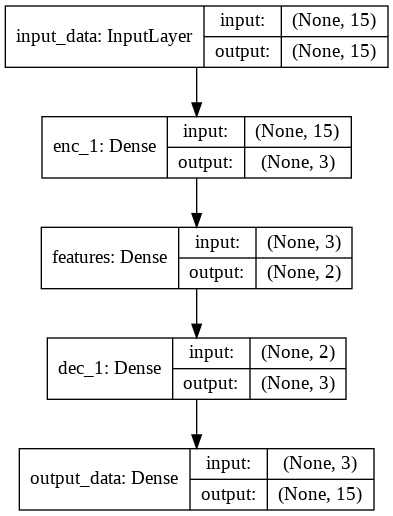

In [0]:
# define la arquitectura de capas del Deep Autoencoder
# teniendo en cuenta la definición dada anteriomente
input_data_Lay = Input(shape=(num_inputs,), name='input_data') # capa de entrada
eachLay = input_data_Lay
auxName = 'enc_'
auxId = 1 
for num_hid in dae_layers:  

    # define el nombre de la capa oculta
    if num_features==num_hid:
        auxlayerName = 'features'
        auxName = 'dec_'
        auxId = auxId - 1
    else:
        auxlayerName = auxName+str(auxId)
        if auxName == 'enc_':
          auxId = auxId + 1
        else:
          auxId = auxId - 1

    # agrega la capa oculta
    eachLay = Dense(num_hid, activation='relu', name=auxlayerName)(eachLay) # capas ocultas

    if num_features==num_hid:
      features_Lay = eachLay

output_data_Lay = Dense(num_outputs, activation=None, name='output_data')(eachLay) # capa de salida

# genera el modelo Deep Autoencoder
DAEmodel = Model(input_data_Lay, output_data_Lay, name='DAE')
DAEmodel.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

print("Modelo DAE creado con ", len(DAEmodel.layers), " capas:")
DAEmodel.summary()
print("\n")
plot_model(DAEmodel, show_layer_names=True, show_shapes=True)

5) Entrenar el modelo DAE:

In [0]:
# lleva a cabo el entrenamiento
# usando los mismos datos como entrada y salida
x_train_prep  = np.array(x_train).reshape(len(x_train), num_inputs)
DAEmodel.fit(x_train_prep, x_train_prep,
                epochs = cantEpocas, 
                batch_size = 5)


Epoch 1/250
81/81 [==============================] - 0s 3ms/step - loss: 1.2169 - acc: 0.0617
Epoch 2/250
81/81 [==============================] - 0s 621us/step - loss: 1.1966 - acc: 0.0123
Epoch 3/250
81/81 [==============================] - 0s 595us/step - loss: 1.1797 - acc: 0.0000e+00
Epoch 4/250
81/81 [==============================] - 0s 583us/step - loss: 1.1632 - acc: 0.0000e+00
Epoch 5/250
81/81 [==============================] - 0s 653us/step - loss: 1.1471 - acc: 0.0000e+00
Epoch 6/250
81/81 [==============================] - 0s 613us/step - loss: 1.1317 - acc: 0.0000e+00
Epoch 7/250
81/81 [==============================] - 0s 792us/step - loss: 1.1164 - acc: 0.0000e+00
Epoch 8/250
81/81 [==============================] - 0s 607us/step - loss: 1.1017 - acc: 0.0000e+00
Epoch 9/250
81/81 [==============================] - 0s 613us/step - loss: 1.0873 - acc: 0.0000e+00
Epoch 10/250
81/81 [==============================] - 0s 605us/step - loss: 1.0739 - acc: 0.0000e+00
Epoch 11/

7) Evaluar el modelo DAE entrenado solicitando que reconstruya los datos de entrenamiento:

In [0]:
# evalua al modelo 
resEval = DAEmodel.evaluate(x_train_prep, x_train_prep)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# procesa las imágenes con el modelo 
reconstr_data = DAEmodel.predict(x_train_prep)

# muestra las 15 primeras imágenes 
print(">Ejemplos de Resultados: ")
for i in range(len(x_train))[:5]:
      
    # muestra la real
    print("  + Original: ", x_train[i])
    # muestra la generada por el modelo
    print("  * Reconstr: ", reconstr_data[i])
    print("  - Dif:      ", reconstr_data[i]-x_train[i])
    print("\n")  

print("> Total de Diferencias ", sum(reconstr_data-x_train))
print("> Promedio de Diferencias ", sum(reconstr_data-x_train)/len(x_train))

81/81 [==============================] - 0s 533us/step

>Evaluación del Modelo: 
    - Error:  0.45649317973925746
    - Exactitud:  76.54321024447312


>Ejemplos de Resultados: 
  + Original:  [0 1 1 0 1 0 1 0 1 1 0 0 2 1 0]
  * Reconstr:  [0.41670832 0.19111997 0.6097855  0.390713   0.24889372 0.3658356
 0.5647253  0.56876975 0.7962931  0.7799109  0.05928412 0.17158878
 2.7191286  0.7341306  0.11582191]
  - Dif:       [ 0.41670832 -0.80888003 -0.3902145   0.39071301 -0.75110628  0.36583561
 -0.43527472  0.56876975 -0.20370692 -0.22008908  0.05928412  0.17158878
  0.71912861 -0.26586938  0.11582191]


  + Original:  [1 0 0 1 0 0 0 1 1 1 0 0 4 1 1]
  * Reconstr:  [0.41670832 0.19111997 0.6097855  0.390713   0.24889372 0.3658356
 0.5647253  0.56876975 0.7962931  0.7799109  0.05928412 0.17158878
 2.7191286  0.7341306  0.11582191]
  - Dif:       [-0.58329168  0.19111997  0.6097855  -0.60928699  0.24889372  0.36583561
  0.56472528 -0.43123025 -0.20370692 -0.22008908  0.05928412  0.17158878

9) Probar el modelo DAE entrenado con los datos de test:

In [0]:
x_test_prep  = np.array(x_test).reshape(len(x_test), num_inputs)

# evalua al modelo 
resEval_test = DAEmodel.evaluate(x_test_prep, x_test_prep)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval_test[0])
print("    - Exactitud: ", resEval_test[1]*100)
print("\n")

# procesa las imágenes con el modelo 
reconstr_data_test = DAEmodel.predict(x_test_prep)

# muestra las 15 primeras imágenes 
print(">Ejemplos de Resultados: ")
for i in range(len(x_test))[:5]:
      
    # muestra la real
    print("  + Original: ", x_test[i])
    # muestra la generada por el modelo
    print("  * Reconstr: ", reconstr_data_test[i])
    print("  - Dif:      ", reconstr_data_test[i]-x_test[i])
    print("\n")  

print("> Total de Diferencias ", sum(reconstr_data_test-x_test))
print("> Promedio de Diferencias ", sum(reconstr_data_test-x_test)/len(x_test))

20/20 [==============================] - 0s 52us/step

>Evaluación del Modelo: 
    - Error:  0.41503024101257324
    - Exactitud:  80.0000011920929


>Ejemplos de Resultados: 
  + Original:  [1 0 0 1 0 0 1 1 1 1 0 0 4 0 0]
  * Reconstr:  [0.41670832 0.19111997 0.6097855  0.390713   0.24889372 0.3658356
 0.5647253  0.56876975 0.7962931  0.7799109  0.05928412 0.17158878
 2.7191286  0.7341306  0.11582191]
  - Dif:       [-0.58329168  0.19111997  0.6097855  -0.60928699  0.24889372  0.36583561
 -0.43527472 -0.43123025 -0.20370692 -0.22008908  0.05928412  0.17158878
 -1.28087139  0.73413062  0.11582191]


  + Original:  [1 0 0 1 0 0 1 1 1 1 0 0 4 1 0]
  * Reconstr:  [0.41670832 0.19111997 0.6097855  0.390713   0.24889372 0.3658356
 0.5647253  0.56876975 0.7962931  0.7799109  0.05928412 0.17158878
 2.7191286  0.7341306  0.11582191]
  - Dif:       [-0.58329168  0.19111997  0.6097855  -0.60928699  0.24889372  0.36583561
 -0.43527472 -0.43123025 -0.20370692 -0.22008908  0.05928412  0.17158878
 

8) A partir del modelo DAE entrenado, generar dos sub-modelos Encoder y Decoder:


*   Generar y usar el modelo Encoder para 'clusterizar' los datos de entrenamiento:


> Modelo Encoder: 
Model: "Encoder/Clustering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      (None, 15)                0         
_________________________________________________________________
enc_1 (Dense)                (None, 3)                 48        
_________________________________________________________________
features (Dense)             (None, 2)                 8         
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


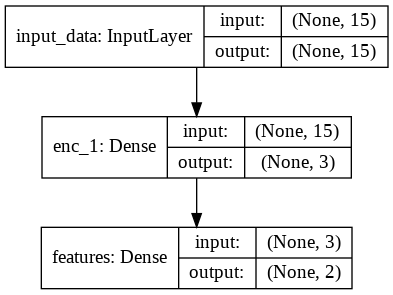

In [0]:
## Generar el sub-modelo Encoder para Clustering
## (desde input hasta features)

# reutiliza las capas entrenadas del modelo DAE original
clust_input_Lay = input_data_Lay  # capa de entrada
clust_output_Lay =  features_Lay  # capa de salida

# genera el modelo
CLUSTmodel = Model(input_data_Lay, features_Lay, name='Encoder/Clustering')

print("> Modelo Encoder: ")
CLUSTmodel.summary()
plot_model(CLUSTmodel, show_layer_names=True, show_shapes=True)



> Estadísticas de Clutering de Datos Originales codificado en  2  valores: 
- Mínimos:    [0. 0.]
- Máximos:    [0.         0.71720493]
- Totales:    [ 0.         11.80886671]
- Promedios:  [0.         0.14578848]





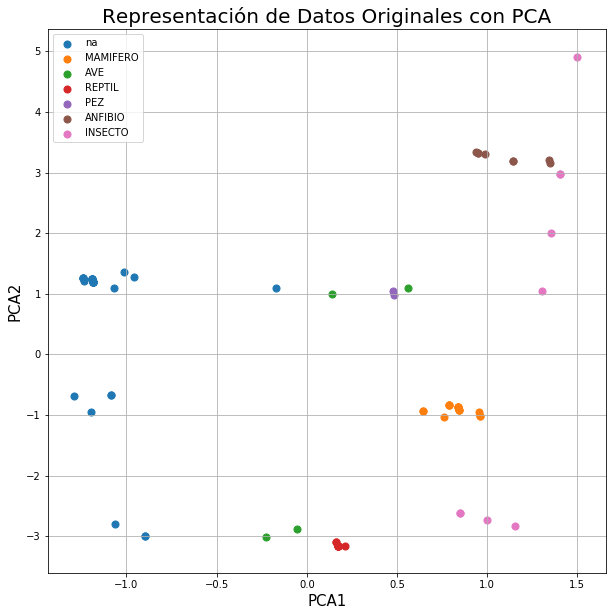

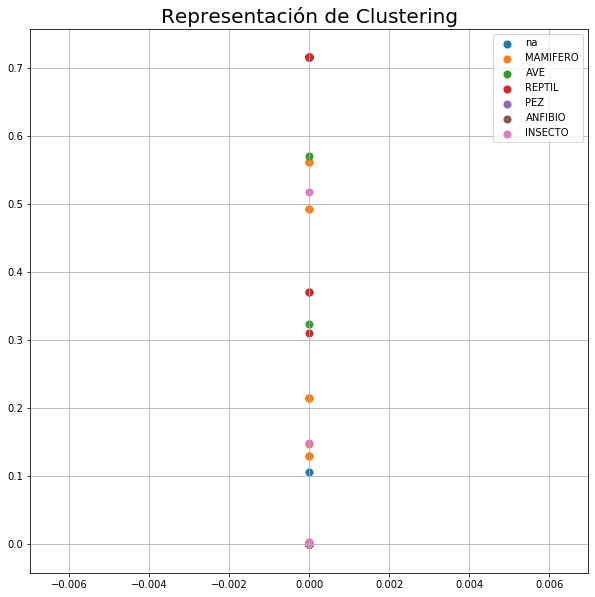

In [0]:
 # función auxiliar para generar un gráfico 
 def genera_grafico(datos, clases, titulo):  
    principalDf = pd.DataFrame(data = datos,
                columns = ['a', 'b'])
    finalDf = pd.concat([principalDf, 
                        pd.DataFrame(clases, columns = ['target'])], 
                        axis = 1)

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_title(titulo, fontsize = 20)
    for target in set(clases):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'a'],
                  finalDf.loc[indicesToKeep, 'b'],
                  s = 50)
    ax.legend(CLASSES)
    ax.grid()


# función auxiliar para generar un gráfico 
# con los valores codificados 
# usando PCA para simplificarlos en 2 ejes
def genera_grafico_pca(datos, clases, titulo):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(datos)
    principalDf = pd.DataFrame(data = principalComponents,
                columns = ['pca_1', 'pca_2'])
    finalDf = pd.concat([principalDf, 
                        pd.DataFrame(clases, columns = ['target'])], 
                        axis = 1)

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PCA1', fontsize = 15)
    ax.set_ylabel('PCA2', fontsize = 15)
    ax.set_title(titulo, fontsize = 20)
    for target in set(clases):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'pca_2'],
                  finalDf.loc[indicesToKeep, 'pca_1'],
                  s = 50)
    ax.legend(CLASSES)
    ax.grid()

# procesa las imágenes para recibir el valor codificado de cada una
x_train_encoded = CLUSTmodel.predict(x_train_prep)

# muestra el gráfico con originales con PCA (para que tenga 2 dimensiones)
genera_grafico_pca(x_train, y_train, "Representación de Datos Originales con PCA")

# muestra estadísticas de los datos codificados
minArClust = np.empty(num_features)
minArClust.fill(9999.99)
maxArClust = np.empty(num_features)
maxArClust.fill(-9999.99)
sumArClust = np.zeros(num_features)
for val in x_train_encoded:
  for i in range(num_features):
      sumArClust[i] = sumArClust[i]+val[i]
      if val[i]<minArClust[i]: 
          minArClust[i] = val[i]
      if val[i]>maxArClust[i]: 
          maxArClust[i] = val[i]
print("\n\n> Estadísticas de Clutering de Datos Originales codificado en ", num_features," valores: ")
print("- Mínimos:   ", minArClust)
print("- Máximos:   ", maxArClust)
print("- Totales:   ", sumArClust)
print("- Promedios: ", sumArClust/len(x_train_encoded))
print("\n\n")

# muestra el gráfico codificado (directo si  tiene 2 dimensiones, sino con PCA)
if num_features==2:
    genera_grafico(x_train_encoded, y_train, "Representación de Clustering")
else:
    genera_grafico_pca(x_train_encoded, y_train, "Representación de Datos Originales con PCA")

*   Generar y usar el modelo Decoder para generar nuevas datos similares a los entrenadas:

> Modelo Decoder: 
Model: "Decoder/Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_gen (InputLayer)       (None, 2)                 0         
_________________________________________________________________
dec_1 (Dense)                (None, 3)                 9         
_________________________________________________________________
output_data (Dense)          (None, 15)                60        
Total params: 69
Trainable params: 69
Non-trainable params: 0
_________________________________________________________________


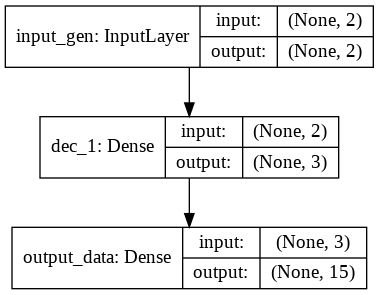

In [0]:
## Generar el sub-modelo Decoder para Generator
## (desde features hasta output)

# genera una copia del modelo DAE original para evitar romperlo
auxiCloneModel = keras.models.model_from_json(DAEmodel.to_json())
#auxiCloneModel.summary()

# genera la nueva estructura del Generator
input_gen = Input(shape=(num_features,), name='input_gen') # nueva capa de entrada
auxLay_gen = input_gen
for pos in range(len(DAEmodel.layers)):

  # obtiene el nombre de la capa actual
  auxName = DAEmodel.layers[pos].name  
  
  # sólo considera las capas luego de features (decoder y output)
  # para copiar los pesos del DAE original y actualizar la estrcutura
  if auxName.startswith('dec_') or auxName=='output_data':
    auxiCloneModel.layers[pos].set_weights(DAEmodel.layers[pos].get_weights()) 
    auxLay_gen = auxiCloneModel.layers[pos](auxLay_gen) 

# crea el nuevo modelo Generator
GENmodel = Model(input_gen, auxLay_gen, name = 'Decoder/Generator')

print("> Modelo Decoder: ")
GENmodel.summary()
plot_model(GENmodel, show_layer_names=True, show_shapes=True)

In [0]:
# ejecuta el Generator
#  usando valores definidos al azar como datos de entrada

cantImagenGenerar = 3

# genera los datos de entrada
# (como la codificación tiene varias posiciones con ceros 
# se considera que sólo se ponen al azar entre 10% y el 70% de los valores, el resto queda en cero,
# --sino se podría hacer con " np.random.rand(cantImagenGenerar, num_features) "-- )
arX = []
minRnd = 1
maxRnd = num_features
for i in range(cantImagenGenerar):
  X = np.zeros(num_features)
  for j in range(np.random.randint(low=minRnd, high=maxRnd)):
      pos = np.random.randint(low=0, high=num_features-1)
      X[pos] = np.random.normal()
      
  arX.append( X )

# ejecuta el modelo Generator
reconstr_data_gen = GENmodel.predict( np.array(arX).reshape((len(arX), num_features)) )  
 
# muestra las imágenes generadas
print("\n> Resultados: ")
# muestra las 15 primeras imágenes 
print("\n>Ejemplos de Resultados: ")
for i in range(len(arX)):
      
    # muestra la real
    print("  + Randoms: ", arX[i])
    # muestra la generada por el modelo
    print("  * Constr.: ", reconstr_data_gen[i])
    print("\n")  




> Resultados: 

>Ejemplos de Resultados: 
  + Randoms:  [-1.46075193  0.        ]
  * Constr.:  [0.41670832 0.19111997 0.6097855  0.390713   0.24889372 0.3658356
 0.5647253  0.56876975 0.7962931  0.7799109  0.05928412 0.17158878
 2.7191286  0.7341306  0.11582191]


  + Randoms:  [-0.78420569  0.        ]
  * Constr.:  [0.41670832 0.19111997 0.6097855  0.390713   0.24889372 0.3658356
 0.5647253  0.56876975 0.7962931  0.7799109  0.05928412 0.17158878
 2.7191286  0.7341306  0.11582191]


  + Randoms:  [0.3044446 0.       ]
  * Constr.:  [ 0.3609254   0.18716432  0.67762166  0.3478486   0.42165387  0.47212076
  0.5642669   0.4552143   0.91539794  0.72861516 -0.00684411  0.19880983
  2.5272188   0.9607171   0.26082513]


